In [138]:
%pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
from glob import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch.nn.functional as F
import requests
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

In [2]:
ROOT_FOLDER =os.getcwd()

In [3]:
print(ROOT_FOLDER)

/Users/abhishekbose/code/pytorch_series


In [8]:
# we need train , test and val split.
class DatasetSplitter:
    def __init__(self) -> None:
        data_path = os.path.join(ROOT_FOLDER,"data","Stanford_dogs","Images")
        print(data_path)
        self.list_of_images = glob(os.path.join(data_path,"*","*.jpg"))

        self.data_dict = {
            "image_paths": [],
            "labels": []
        }

        self.data_df = None
        self.__prepare_dataset()
    
    def __prepare_dataset(self):
        """
        In this function we are going to load the images along with the labels 
        and create a datframe out of it
        """
        for image_path in self.list_of_images:
            label = image_path.split(os.path.sep)[-2].split('-')[-1]
            self.data_dict["image_paths"].append(image_path)
            self.data_dict["labels"].append(label)
        
        self.data_df = pd.DataFrame(self.data_dict)
        self.data_df = (self.data_df.sample(frac=1,random_state=42).reset_index()).drop(columns="index") #shuffle the dataset
        #let's encode the labels

        label_encoder = LabelEncoder()
        label_transformer = label_encoder.fit(self.data_df.labels.to_list())
        self.data_df['converted_labels'] = self.data_df.apply(lambda row: label_transformer.transform([row.labels])[0],axis=1)

    def __len__(self):
        return len(self.list_of_images)


    #split the dataset

    def split_dataset(self):
        val_ratio = test_ratio = 0.2
        train, test = train_test_split(self.data_df,test_size=test_ratio,random_state=42)
        val, test = train_test_split(test,test_size=val_ratio,random_state=42)

        return train,val,test



In [9]:
dataset_spliiter = DatasetSplitter()

/Users/abhishekbose/code/pytorch_series/data/Stanford_dogs/Images


In [10]:
train, val, test = dataset_spliiter.split_dataset()

In [11]:
train.shape

(16464, 3)

In [12]:
val.shape

(3292, 3)

In [13]:
test.shape

(824, 3)

In [14]:
train.head()

,image_paths,labels,converted_labels
16375,/Users/abhishekbose/code/pytorch_series/data/S...,Old_English_sheepdog,49
16615,/Users/abhishekbose/code/pytorch_series/data/S...,coated_retriever,86
10098,/Users/abhishekbose/code/pytorch_series/data/S...,golden_retriever,93
7677,/Users/abhishekbose/code/pytorch_series/data/S...,tan_coonhound,114
18717,/Users/abhishekbose/code/pytorch_series/data/S...,Airedale,2


In [15]:
train.labels.value_counts()

coated_retriever       240
Maltese_dog            211
Afghan_hound           186
Scottish_deerhound     185
Leonberg               181
                      ... 
Pekinese               113
kuvasz                 111
Sussex_spaniel         108
Irish_water_spaniel    108
dhole                  107
Name: labels, Length: 119, dtype: int64

In [16]:
val.labels.value_counts()

coated_retriever        50
Afghan_hound            43
Pomeranian              42
Norwegian_elkhound      38
Irish_wolfhound         38
                        ..
clumber                 16
komondor                16
Weimaraner              16
Border_collie           16
Bouvier_des_Flandres    16
Name: labels, Length: 119, dtype: int64

In [17]:
#splitting the dataset in X and Y

X_train,y_train = train['image_paths'], train['converted_labels']
X_val,y_val = val['image_paths'], val['converted_labels']
X_test,y_test = test['image_paths'], test['converted_labels']


In [18]:
X_train.head()

16375    /Users/abhishekbose/code/pytorch_series/data/S...
16615    /Users/abhishekbose/code/pytorch_series/data/S...
10098    /Users/abhishekbose/code/pytorch_series/data/S...
7677     /Users/abhishekbose/code/pytorch_series/data/S...
18717    /Users/abhishekbose/code/pytorch_series/data/S...
Name: image_paths, dtype: object

In [19]:
y_train.head()

16375     49
16615     86
10098     93
7677     114
18717      2
Name: converted_labels, dtype: int64

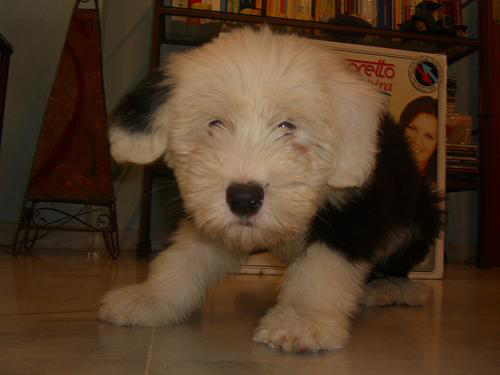

In [20]:
Image.open(X_train.iloc[0])

In [21]:
#Creating the dataloader

class StanfordDogs(Dataset):
    def __init__(self,X_df: pd.DataFrame,Y_df:pd.DataFrame,transform=None,target_transform=None) -> None:
        super().__init__()

        self.transform = transform
        self.target_transform = target_transform

        self.X= X_df
        self.Y = Y_df

    def __getitem__(self,index):
        row = self.X.iloc[index]
        image= Image.open(row).convert('RGB')
        label = self.Y.iloc[index]

        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)

        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)



In [22]:
dataset_train = StanfordDogs(X_train,y_train,
                transform=Compose([
                    Resize((224,224)),
                    ToTensor(),
                    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]))

In [23]:
len(dataset_train)

16464

In [24]:
dataset_train.X.iloc[0]

'/Users/abhishekbose/code/pytorch_series/data/Stanford_dogs/Images/n02105641-Old_English_sheepdog/n02105641_2018.jpg'

In [25]:
image,label = dataset_train[30]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


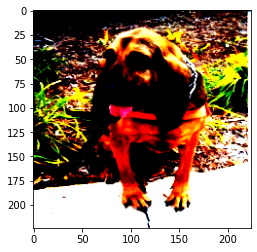

In [26]:
plt.imshow(image.permute(1,2,0))

In [27]:
dataset_val = StanfordDogs(X_val,y_val,
                transform=Compose([
                    Resize((224,224)),
                    ToTensor(),
                    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]))

In [28]:
image, label = dataset_val[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


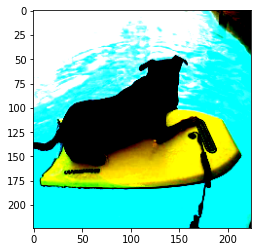

In [29]:
plt.imshow(image.permute(1,2,0))
plt.show()

In [30]:
#let's create the dataloaders
train_dataloader = DataLoader(dataset_train,batch_size=32,shuffle=True)

In [31]:
val_dataloader = DataLoader(dataset_val,batch_size=32,shuffle=True)

In [32]:
item,label = next(iter(train_dataloader))

In [33]:
item.shape

torch.Size([32, 3, 224, 224])

In [34]:
label.shape

torch.Size([32])

In [35]:
label

tensor([ 86,  60,  33,  26,  41,   6, 103,  82, 100,  26,  23,  86,  72,  59,
         60,  73,  47,  88,  26,  22,   6,  37,  84,  63, 108, 112,  66,  40,
         24,  96, 113,  99])

In [36]:
#model creation and training

num_classes = len(train.converted_labels.unique())

In [37]:
num_classes

119

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
device

device(type='cpu')

In [40]:
#pre-trained model
model = models.resnet18(pretrained=True)

/opt/anaconda3/envs/pytorch_series/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/pytorch_series/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
#imagenet 1000 classes.
#update output layer to match our number of classes

#only fine-tune 

num_features = model.fc.in_features

In [43]:
num_features

512

In [44]:
#update model final layer
model.fc = nn.Linear(num_features,num_classes)

In [45]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
model = model.to(device)

In [47]:
criterion_loss = nn.CrossEntropyLoss()

In [48]:
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [49]:
#dictionary of dataloaders
dataloders = {
    "train":train_dataloader,
    "val" : val_dataloader
}

In [50]:
dataset_sizes = {
    "train": len(dataset_train),
    "val" : len(dataset_val)
}

In [51]:
dataloders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f90201aaa30>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f90328bac70>}

In [52]:
dataset_sizes

{'train': 16464, 'val': 3292}

In [53]:
#function to train the model

def train(model,criterion, optimizer, num_epochs=10):
    start_time = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        #Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train() #set model to training mode
            else:
                model.eval() #set model to evalueate model (no param update)

            running_loss = 0.0
            running_corrects = 0

            #Iterate over the data
            print(f"Current phase is --> {phase}")
            with tqdm(dataloders[phase],unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    #zero out the parameter gradients

                    optimizer.zero_grad()

                    #forward step
                    #track history only if training phase
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs,labels)

                        #perform back prop and update weights only in training phase
                        if phase == "train":
                            loss.backward() # <==== back prop step
                            optimizer.step() # <==== weight update step

                    
                    #update the stats
                    running_loss += loss.item()*inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        #deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
    

    time_elapsed = time.time() - start_time
    print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val acc: {best_acc:4f}")


    #load best weights
    model.load_state_dict(best_model_weights)
    return model


            

In [56]:
trained_model = train(model, criterion_loss, optimizer,
                       num_epochs=25)

Epoch 0/24
----------
Current phase is --> train


 15%|█▍        | 76/515 [05:32<31:58,  4.37s/batch]


KeyboardInterrupt: 